(<Figure size 576x225 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f816828bac0>)

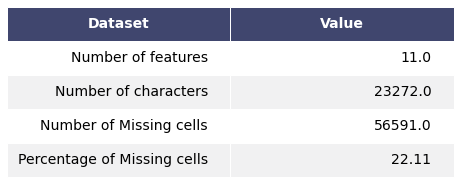

In [8]:
import pickle
import sys
sys.path.insert(1, '../src')
from render_table import render_table

feature_overview_df = pickle.load(open("../results/tables/feature_overview.pkl", "rb"))

render_table(dataset_overview_df, header_columns=0, col_width=4)

![Alignment Over Time](../results/figures/alignment_over_time.png)
![Alignment Vs Features](../results/figures/alignment_vs_features.png)
![Alignment By Alignment](../results/figures/appearances_by_alignment.png)

## Discussion: line chart of Alignment over Time

The line chart demonstrates how the characters count changes over year for each class of the alignments. One observation is that all the alignments seem to move in the same direction over time, but to different extents. Bad characters are created the most for most years from 1935 to 2013. Another interesting finding is that we have noticable amount of null alignments in our data. It would be misleading to replace the missing values with any classes, and therefore, we decided to split those null alignment out as deployment data set. The alignments will then be predicted using our best selected model.

## Discussion: scatter plots of each feature

The scatter plot provides a quick glance over the frequency of all categories of each feature. This visual is helpful to identify which category buckets does bad (or other) characters falls into for each feature. Some of the interesting findings are listed as following:
- Majority of the bad characters has secret identify;
- Good characters with public identify is comparable with those with secret identify;
- For blond-hair characters, they are more likely to be bad characters. 
- Marvel characters created a lot more bad character proportionally than dc did. 

## Discussion: character appearances distribution by alignment

The box plot indicates the distribution of character appearances in comic books for good, bad and neutral characters. We have skewed distribution for all three classes. The majority number of character appearance in comic book is less than 50, indicated by the median lines of all three box plots. Second key observation is that good characters controls the majority of the appearances among all.